In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные из csv файла в DataFrame и отберем их

In [2]:
dataframe = pd.read_csv('data.csv')
dataframe.head()

,sum_data,max_pkt,pkt_count,avg_pkt,flow_speed,pkt_speed,delta_med,delta_min,status
0,5068074.0,8760.0,1278.0,3965.629108,1.013587e+06,255.593016,0.000566,2.384186e-07,0.0
1,11931634.0,8760.0,2181.0,5470.717102,2.364582e+06,432.225320,0.000707,2.384186e-07,0.0
2,10780930.0,8760.0,2027.0,5318.663049,2.141800e+06,402.695129,0.000622,2.384186e-07,0.0
3,9932642.0,8760.0,1924.0,5162.495842,1.986272e+06,384.750392,0.000656,2.384186e-07,0.0
4,13326703.0,8760.0,2336.0,5704.924229,2.602427e+06,456.172115,0.000704,2.384186e-07,0.0


При отборе данных для "имитации" пользовательской нагрузки использовался Apache-Jemeter, шаблон запросов представлен в файле requests.jmx 

Либо лично я не смог найти как изменить межпакетный интервал, либо же данная функция не предусмотрена, параметр delta_min при обучении мы опустим, тк на всех данных он равен одному значению.
Можно конечно было попробовать изменить его значение на рандомное, исходя из delta_med, однако пока что обойдемся без этого.
Также проблемы могут возникнуть с значениями столбца max_pkt, хоть при сборе статистики файл шаблонных запросов менялся(примерно раз в 1-2 часа), данные сильно повторяются, пока что этот параметр оставим, но в дальнейшем попробуем проэксперементировать с этим параметром.

In [3]:
del dataframe['delta_min'] 

In [4]:
from sklearn.ensemble import RandomForestClassifier

<BarContainer object of 7 artists>

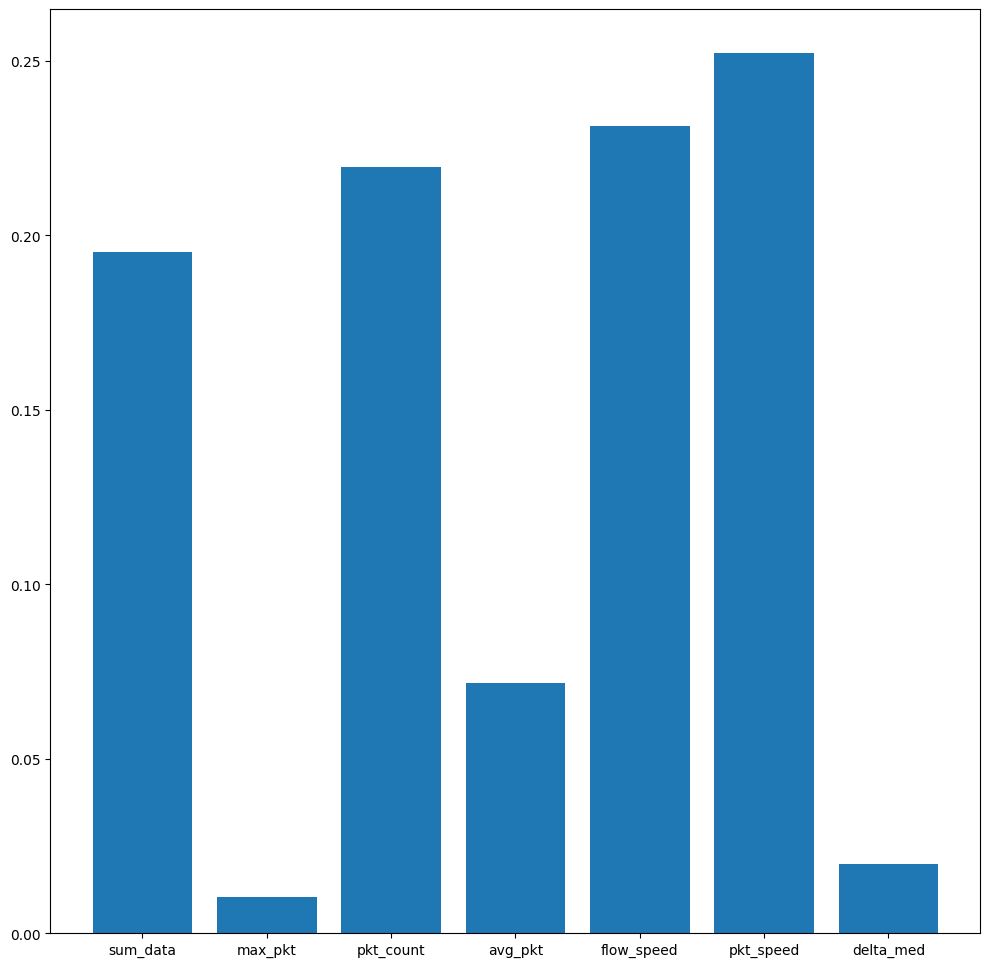

In [5]:
clf = RandomForestClassifier()
X = dataframe[['sum_data','max_pkt','pkt_count','avg_pkt','flow_speed','pkt_speed','delta_med']].copy()
y = dataframe['status'].copy()
clf.fit(X, y)
plt.figure(figsize=(12,12))
plt.bar(X.columns, clf.feature_importances_)

Заметим, что в нашем случае параметры msx_pkt и delta_med оказывают наименьшее влияние

In [6]:
from sklearn.metrics import f1_score, accuracy_score 
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [8]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [9]:
rfc = RandomForestClassifier()

Займемся поиском наилучших гиперпараметров для нашей модели.

In [10]:
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train.values, y_train.values)
rfc = gs.best_estimator_
print(gs.best_params_)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
{'bootstrap': False, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [11]:
y_pred = rfc.predict(X_test.values)
f1_score(y_pred, y_test)

1.0

Видим, что оценка модели по f1 мере составляет 99-100%, что очевидно является показателем странным. Возможно имеет место переобучение, однако когда я проводил обучение на меньших объемах данных, увеличивал тестовую выборку, результат не менялся, поэтому делаю вывод: дело в данных. Хоть набор и показывает себя хорошо на "искуственных" данных, он нерепрезентативен для настоящей задачи.

In [12]:
import joblib

In [13]:
joblib.dump(rfc, 'model1.pkl')

['model.pkl']

Сохраним полученную модель. 